In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
print ("Total de estudos primários usados como Seed Set: ", len ([x for _, x in load_work_map_all_years() if x.category == "snowball"]))


Total de estudos primários usados como Seed Set:  51


In [4]:
print ("Lista de estudos primários usados como Seed Set:")
([x for _, x in load_work_map_all_years() if x.category == "snowball"])

Lista de estudos primários usados como Seed Set:


[Exploring the use of the cynefin framework to inform software development approach decisions,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Application of GQM+ Strategies in a small software development unit,
 A cynefin based approach to process model tailoring and goal alignment,
 Aligning Organizations Through Measurement,
 A conceptual framework for SPI evaluation,
 The effects of gqm+strategies on organizational alignment,
 Experiences and insights from applying gqm+ strategies in a systems product development organisation,
 Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach,
 A framework for systematic evaluation of process improvement priorities,
 Strategically balanced process adoption,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Aligning software projects with business objectiv

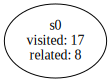

In [5]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


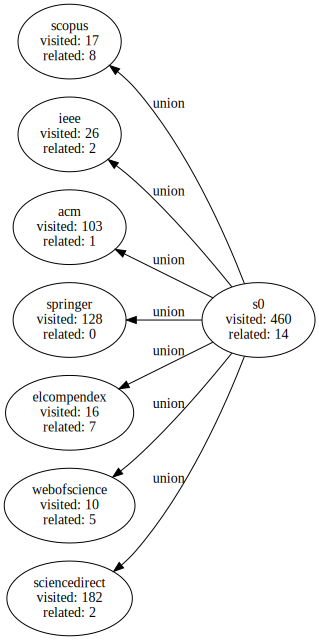

In [6]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus", "ieee", "acm", "springer", "elcompendex", "webofscience", "sciencedirect"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [7]:
array = []

print ("--- Estratégia 1 (E1) ---")

name = "E1"
EP = len (state.related) / len (state.visited)
print ("Precision: " + "%.2f" %EP)

ER = len (state.related) / len (TOTAL)
print ("Recall: " + "%.2f" %ER)

FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.2f" %FS)

array.append((name, EP, ER, FS))

--- Estratégia 1 (E1) ---
Precision: 0.47
Recall: 0.16
F-Measure: 0.24


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

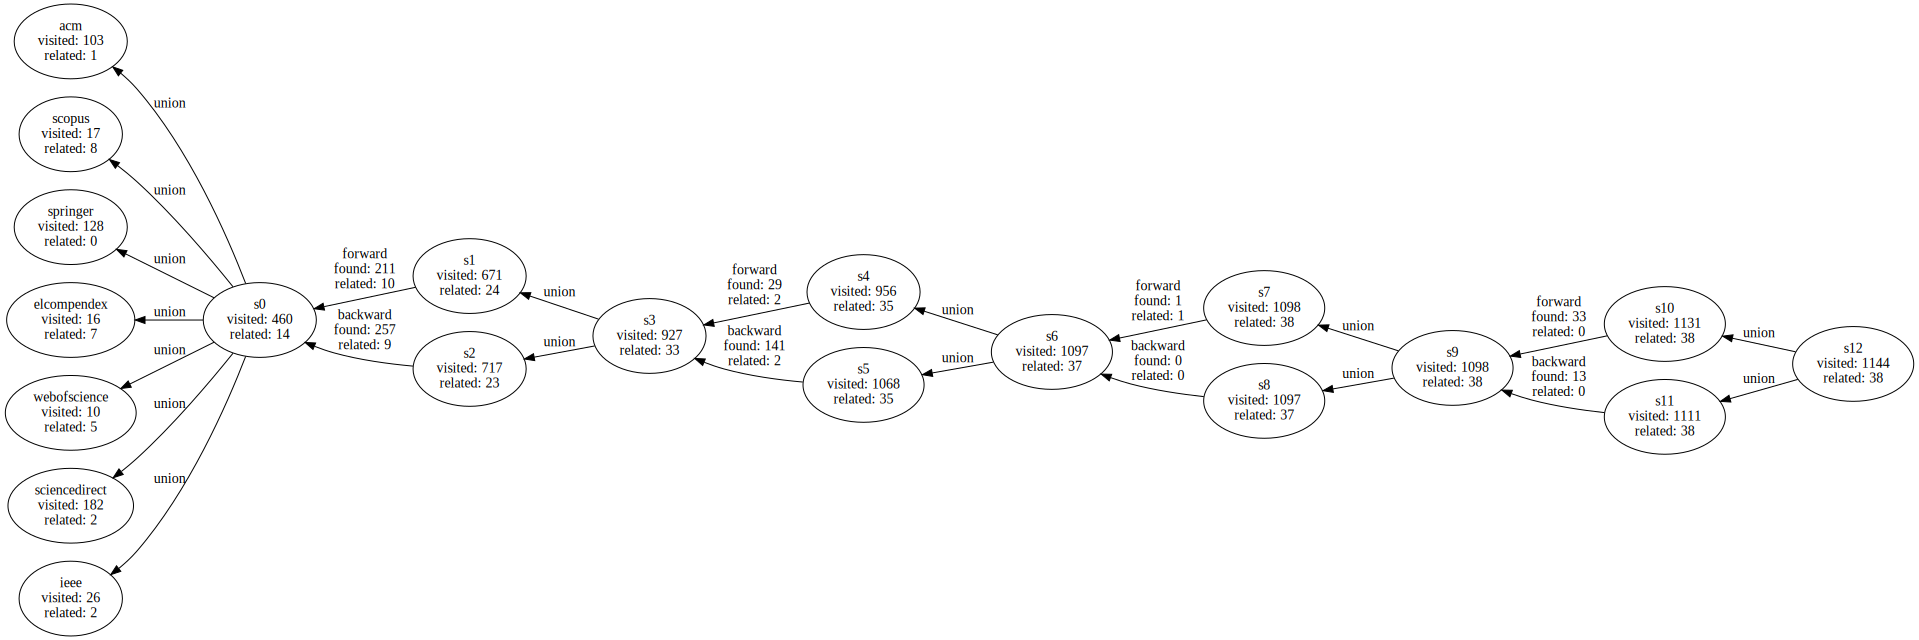

In [8]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus", "springer", "elcompendex", "webofscience", "sciencedirect", "ieee"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

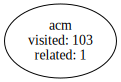

In [9]:
strategy.initial.find("acm")

In [10]:
# Visitados ACM
strategy.initial.find("acm").visited

{Legal Goal-oriented Requirement Language (Legal GRL) for Modeling Regulations,
 Thinkflickrthink: A Case Study on Strategic Tagging,
 Design Goal-oriented Level Design,
 Three Integration Approaches for Map and B-SCP Requirements Engineering Techniques,
 Managing with Web-based IT in Mind,
 Experience with Adapting a WS-BPEL Runtime for eScience Workflows,
 Improved Text Annotation with Wikipedia Entities,
 Early Phase Requirements Assessment of a Teletreatment Trial,
 ESAO: Towards Data- and Ecosystem-driven R&#38;D,
 Rapid Design Labs: A Tool to Turbocharge Design-led Innovation,
 How Older and Younger Adults Differ in Their Approach to Problem Solving on a Complex Website,
 Uncovering and Testing Archetypes of Effective Public Sector CIOs,
 HyperIntelligence: The Next Frontier,
 Analyzing Trust in Technology Strategies,
 Aligning Security and Business Objectives for Process-Aware Information Systems,
 Alignment of Information Systems to Strategy in the Health Sector Using a Systems

In [11]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("webofscience").related

{ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

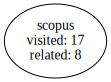

In [12]:
strategy.initial.find("scopus")

In [13]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{An approach to support the strategic alignment of software process improvement programs,
 A comparative study of SPI approaches with ProPAM,
 Demanding change: How to remain in business despite IT,
 Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Critical success factors in software process improvement: A systematic review,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Empirical evaluation of selected best practices in implementation of software process improvement,
 Using strategic planning for selection of SPI processes: An experience report,
 A case study applying process and project alignment methodology,
 Application of G

In [14]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [15]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [16]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


684

In [17]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{ProPAM: SPI based on Process and Project Alignment,
 The effects of gqm+strategies on organizational alignment,
 Measuring and improving software process in China,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 SAS: A tool for the GQM+strategies grid derivation process,
 Determining organization-specific process suitability,
 Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach,
 Entropy based software processes improvement,
 Aligning Organizations Through Measurement,
 Aligning software-related strategies in multi- organizational settings,
 Interfacing three complementary technologies: Strategic planning, process modeling, and system dynamics,
 A conceptual framework for SPI evaluation,
 Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA),
 Utilizing GQM+ Strategies for an organization-wide earned value analysis,
 QFD Application in Softwa

In [18]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s2").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['münch2013a - The effects of gqm+strategies on organizational alignment',
 'armbrust2010a - Determining organization-specific process suitability',
 'unterkalmsteiner2014a - A conceptual framework for SPI evaluation',
 'wang2005a - Measuring and improving software process in China',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach',
 'karlström2002a - Aggregating viewpoints for strategic software process improvement\x97a method and a case study',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
 'murugappan2003a - Blending CMM and Six Sigma to meet business goals',
 'cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'mandić2010a - Utilizing GQM+ Strategies for an 

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [19]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{A survey of software engineering practices in Turkey,
 An approach to support the strategic alignment of software process improvement programs,
 The effect of clusters on the development of the software industry in Dalian, China,
 Demanding change: How to remain in business despite IT,
 Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 Investigating the relationship between schedules and knowledge transfer in software testing,
 The Dimensions of Embedded COTS and OSS Software Component Integration,
 Two Smaller Case Histories,
 Improved Text Annotation with Wikipedia Entities,
 A Survey of Service Identification Strategies,
 Early Phase Requirements Assessment of a Teletreatment Trial,
 Software Thinking Improvement Learning Performance Improving Lessons,
 Assessment methodology for software process improvement in small organizations,
 Experiences on establishing software processes in small comp

#### Relacionados - Seed Set

In [20]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['barreto2010a - Defining and monitoring strategically aligned software improvement goals',
 'becker2008a - An approach to support the strategic alignment of software process improvement programs',
 'mandić2010b - Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals',
 'kaneko2011a - Application of GQM+ Strategies{\textregistered} in the Japanese space industry',
 'wilkie2007a - A Low-overhead method for software process appraisal',
 "reiblein1997a - SPI:\x91I can't get no satisfaction\x92-directing process improvement to meet business needs",
 'plösch2011a - Software engineering strategies: aligning software process improvement with strategic goals',
 'trienekens2005a - Business-oriented process improvement: practices and experiences at Thales Naval The Netherlands (TNNL)',
 'martins2008a - ProPAMet: a Metric for process and project alignment',
 'basili2010a - Linking software development and business strategy through measurement',
 'sommerv

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [21]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{Beyond computation: Information technology, organizational transformation and business performance,
 ProPAM: SPI based on Process and Project Alignment,
 CMMI: Guidelines for Process Integration and Product Improvement,
 The book, Successful Software Process Improvement Upper Saddle River,
 SOFTEX: version 1.2,
 Simple metrics for improving software process performance and capability: A case study,
 Improving Software Quality: An Insider's Guide to TQM,
 Software measurement: Establishextractevaluateexecute,
 ITIL - The Information Technology Infrastructure Library,
 Organizational alignment and performance: Past, present and future,
 The Goal/Question/Metric Method: A Practical Guide for Quality Improvement of Software Development,
 Guidelines for Auditing Quality Systems,
 The balanced scorecard--measures that drive performance,
 Information Technology - Process Assessment - Part 5: An exemplar Process Assessment Model,
 Blue Ocean Strategy,
 The capability maturity model: Guidel

In [22]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['liu2005a - QFD Application in Software Process Management and Improvement Based on CMM',
 'martins2007b - ProPAM: SPI based on Process and Project Alignment',
 'basili2007a - Bridging the gap between business strategy and software development',
 'basili2007b - GQM+Strategies - Aligning business strategies with software measurement',
 'trienekens2009a - Entropy based software processes improvement',
 'kowalczyk2010a - Aligning software-related strategies in multi- organizational settings',
 'mccoy1998a - Interfacing three complementary technologies: Strategic planning, process modeling, and system dynamics',
 'debou2000a - Linking software process improvement to business strategies: Experiences from industry',
 'becker2008b - Strategic alignment of software process improvement programs using QFD']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [23]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['karlström2002a - Aggregating viewpoints for strategic software process improvement\x97a method and a case study',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
 'cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis',
 'unterkalmsteiner2014a - A conceptual framework for SPI evaluation',
 'trendowicz2011a - Aligning software projects with business objectives',
 'mandić2010d - SAS: A tool for the GQM+strategies grid derivation process']

#### Relacionados - Encontrados Via Backward e Forward

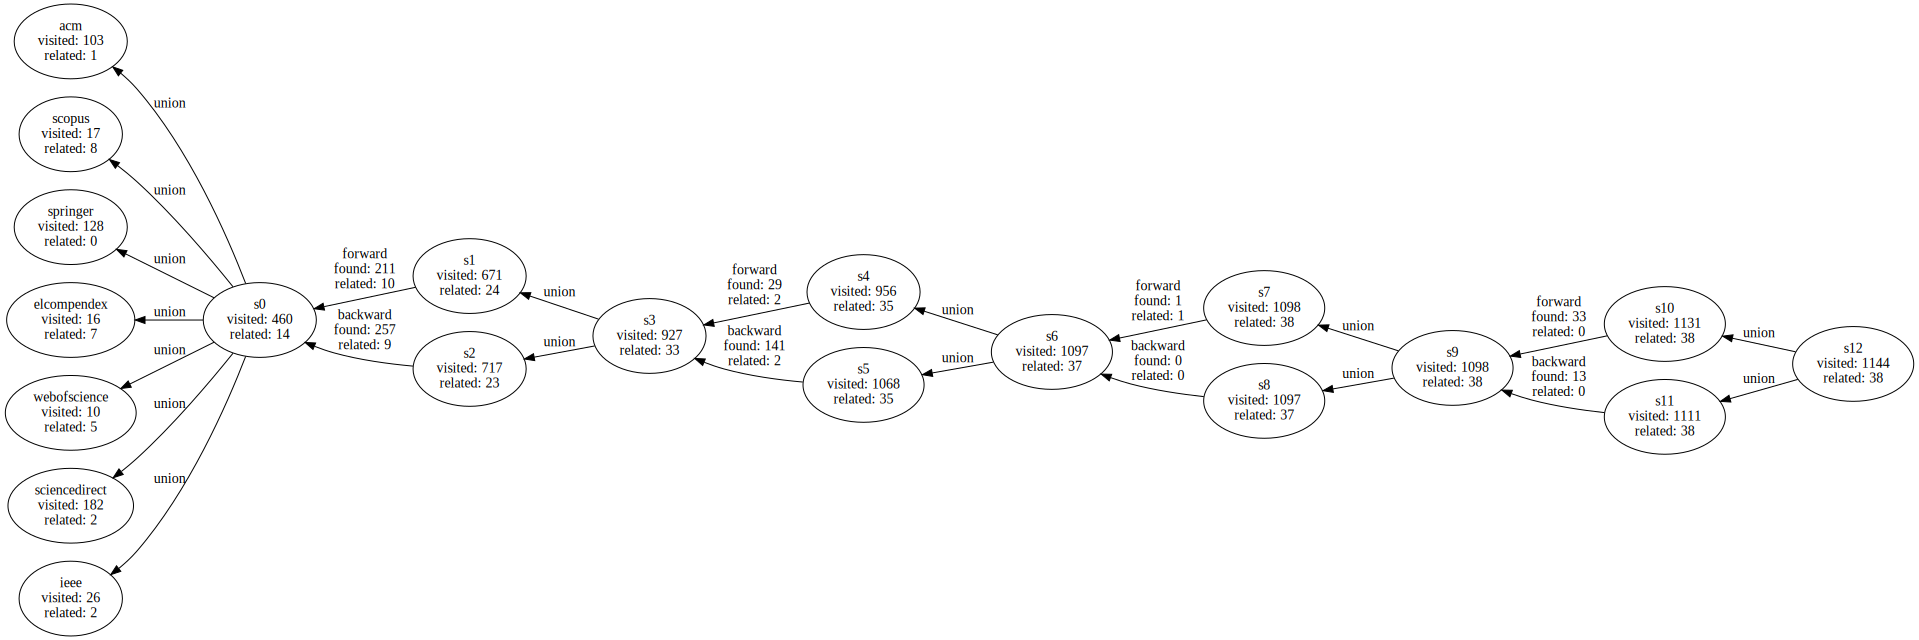

In [24]:
state

In [25]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm").visited) + len(strategy.initial.find("scopus").visited) + len(strategy.initial.find("elcompendex").visited) + len(strategy.initial.find("springer").visited) + len(strategy.initial.find("webofscience").visited) + len(strategy.initial.find("sciencedirect").visited)) - len(state.find("s0").visited)

-4

In [26]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['liu2005a - QFD Application in Software Process Management and Improvement Based on CMM',
  'martins2007b - ProPAM: SPI based on Process and Project Alignment',
  'münch2013a - The effects of gqm+strategies on organizational alignment',
  'basili2007b - GQM+Strategies - Aligning business strategies with software measurement',
  'murugappan2003a - Blending CMM and Six Sigma to meet business goals',
  'debou2000a - Linking software process improvement to business strategies: Experiences from industry',
  'basili2007a - Bridging the gap between business strategy and software development',
  'becker2008b - Strategic alignment of software process improvement programs using QFD',
  'trienekens2009a - Entropy based software processes improvement',
  'kowalczyk2010a - Aligning software-related strategies in multi- organizational settings',
  'mccoy1998a - Interfacing three complementary technologies: Strategic planning, process modeling, and system dynamics'],
 ['karlström2002a - Aggregating

In [27]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [28]:
strategy.forward??

In [29]:
duplicados(strategy, state)

0

<IPython.core.display.Javascript object>


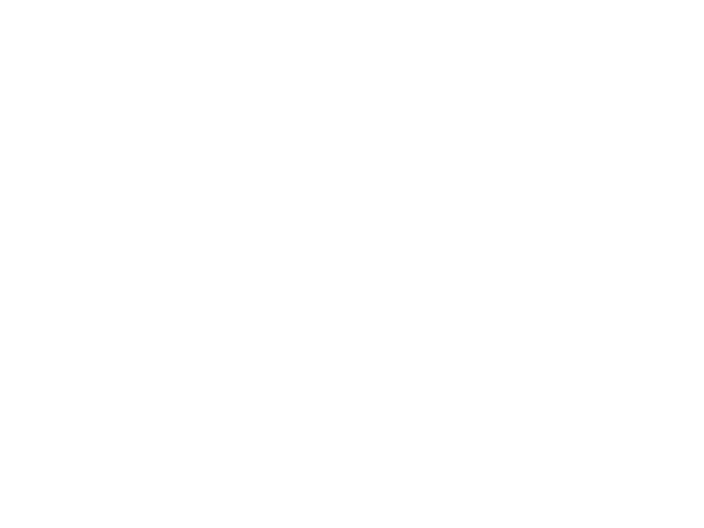

In [30]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [31]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['liu2005a', 'basili2007a', 'martins2007b', 'münch2013a', 'basili2007b', 'trienekens2009a', 'murugappan2003a', 'kowalczyk2010a', 'mandić2010a', 'mccoy1998a', 'trendowicz2011a', 'mandić2010d', 'debou2000a', 'becker2008b']
Forward ['wang2005a', 'karlström2002a', 'petersen2015a', 'cocozza2014a', 'armbrust2010b', 'mandić2010d', 'becker2008b', 'armbrust2010a', 'stallinger2013a', 'trendowicz2014a', 'münch2013c', 'unterkalmsteiner2014a', 'trendowicz2011a', 'mandić2010a']


In [32]:
state.find("s0").related @ metakey

['barreto2010a',
 'becker2008a',
 'mandić2010b',
 'kaneko2011a',
 'wilkie2007a',
 'reiblein1997a',
 'plösch2011a',
 'trienekens2005a',
 'martins2008a',
 'basili2010a',
 'sommerville1999a',
 'albuquerque2009a',
 'sun2010a',
 'guzmán2010a']

In [33]:
#x = v.get_patch_by_id('100')

In [34]:
#x.set_linestyle = "black"

In [35]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [36]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward barreto2010a
- markovic2008a 
- pmi2004a 
- chrissis2003a 
- rocha2006a 
- conradi2002a 
- pu2006a 
- kaplan1996a 
- huang2009a 
- russell1995a 
- itgi2010a 
- dyba2005a 
- uraikul2007a 
- thomas2005a 
- montoni2007a 
- basili2007b related
- mintzberg2000a 
- castillo2007a 
- chiavenato2000a 
- becker2008b related
- softex2010a 
- basili1994a 
- park1996a 
backward becker2008a
- debou1999a 
- chrissis2003a 
- yin2003a 
- grady1997a 
- akao1990a 
- yamamura1999a 
- humphrey1989b 
- paulk1993a 
- mccoy1998a related
- dyba2005a 
- pulford1996a 
- liu2005a related
- hierholzer1998a 
- weber2005a 
- brodman1995a 
- montoni2007a 
- pitterman2000a 
- cox1992a 
- biró1999a 
- isoiec2003a 
- niazi2003a 
- zaijun2005a 
- peterson1995a 
- zahran1998a 
backward mandić2010b
- brynjolfsson2000a 
- thorp2003a 
- berry2006a 
- solingen2004a 
- basili1984a 
- basili1993a 
- little2004a 
- boehm2003b 
- erdogmus2004a 
- harr

#### Execução de Forward em cada artigo relacionado do S1

In [37]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward barreto2010a
- khraiwesh2013a 
- trinkenreich2015a 
- ardila2013b 
- barcellos2010a 
- barreto2011a 
- ardila2013a 
backward mandić2010b
- mandić2010c 
forward mandić2010b
- asghari2012a 
- papa2015a 
- tyrväinen2015a 
- roditi2014a 
- basili2014b 
- hyvönen2015a 
- ellis2012a 
- astromskis2014a 
- petersen2015a related
- trendowicz2014a related
- münch2013c related
- mandić2010g 
- basili2014c 
- cocozza2014a related
- kobori2014a 
- mandić2010a related
- dymek2015a 
- fernández2011a 
- kobori2014b 
- ellis2013a 
forward kaneko2011a
- asghari2012a 
- heidrich2012b 
- teixeira2013a 
- trinkenreich2015a 
- petersen2015a related
- razón2014b 
- kobori2014a 
- razón2014a 
forward wilkie2007a
- taylor2009a 
- zarour2009a 
- napier2009a 
- lester2010a 
- laporte2009a 
- zarour2009b 
- zarour2011a 
- al2013a 
- lester2007a 
forward reiblein1997a
- alshawi2007a 
- schalken2007a 
- murakami2007a 
- bowers2001a 
- bro

#### Resumo do Precision e Recall

In [38]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)
print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))


Precision na Busca E2: 0.03%

Precision no Snowballing E2: 0.04%
Precision no Snowballing E2 - Forward - 1 iteração: 0.05%
Precision no Snowballing E2 - Backward - 1 iteração: 0.04%

Precision E2 (Busca + Snowballing): 0.03%
Precision E2
0.033216783216783216
Recall E2
0.7450980392156863
F-measure E2
0.06359832635983263


In [39]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [40]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

20,state,precision,recall,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall
0,ieee,0.0769231,0.0392157,-,2,26,2,26,0.0769231,0.0392157
1,sciencedirect,0.010989,0.0392157,-,2,182,2,182,0.010989,0.0392157
2,webofscience,0.5,0.0980392,-,5,10,5,10,0.5,0.0980392
3,elcompendex,0.4375,0.137255,-,7,16,7,16,0.4375,0.137255
4,springer,0,0,-,0,128,0,128,0,0
5,scopus,0.470588,0.156863,-,8,17,8,17,0.470588,0.156863
6,acm,0.00970874,0.0196078,-,1,103,1,103,0.00970874,0.0196078
7,s0,0,0,union,14,460,0,0,0.0304348,0.27451
8,s2,0.0350195,0.176471,backward,23,717,9,257,0.0320781,0.45098
9,s1,0.0473934,0.196078,forward,24,671,10,211,0.0357675,0.470588


<IPython.core.display.Javascript object>


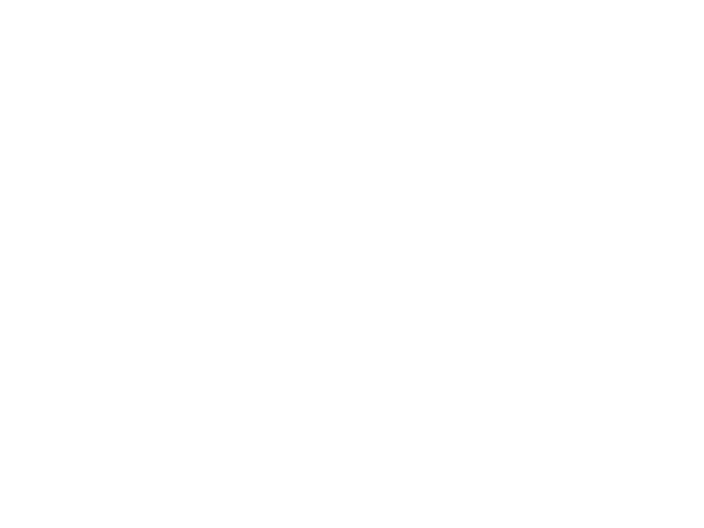

In [41]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

<IPython.core.display.Javascript object>


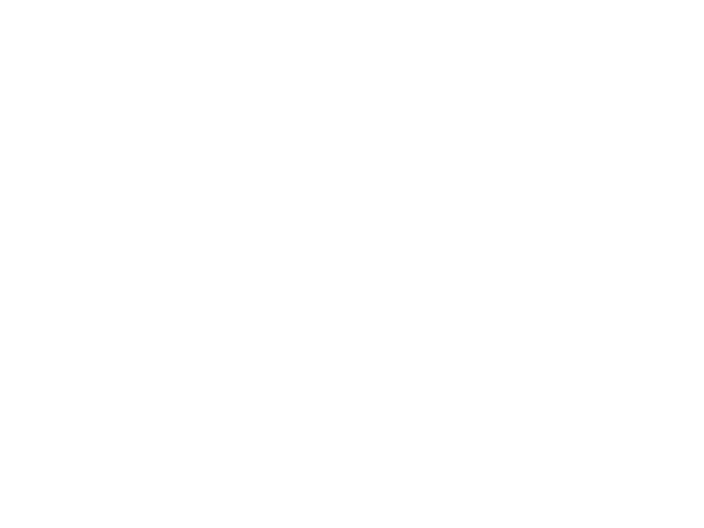

In [42]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

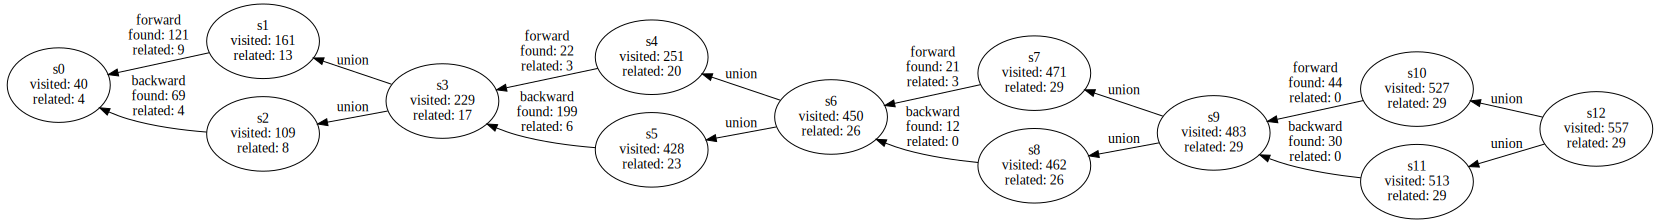

In [43]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [44]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E3
0.05206463195691203
Recall E3
0.5686274509803921
F-measure E3
0.09539473684210527



## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

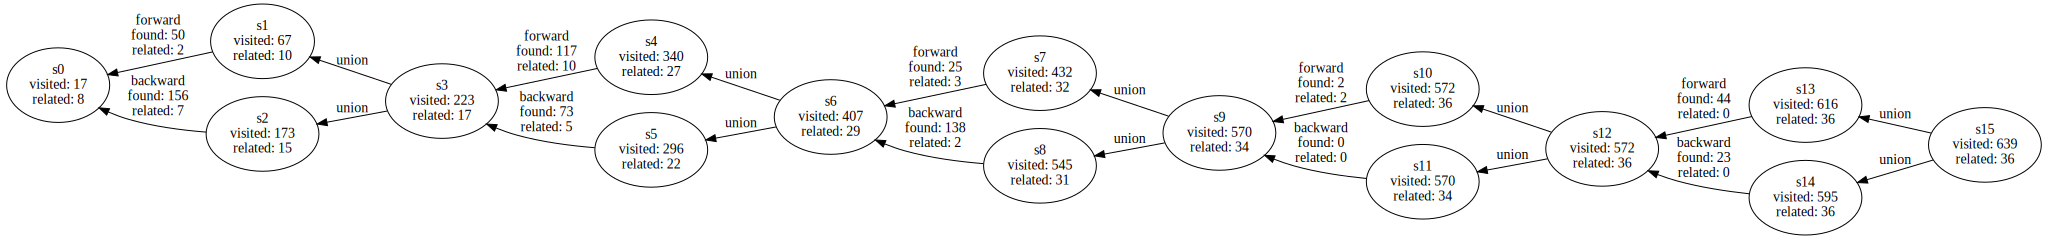

In [45]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
state

In [46]:
descreve_delta(strategy, state, "s2")


backward becker2008a
- debou1999a 
- chrissis2003a 
- yin2003a 
- grady1997a 
- akao1990a 
- yamamura1999a 
- humphrey1989b 
- paulk1993a 
- mccoy1998a related
- dyba2005a 
- pulford1996a 
- liu2005a related
- hierholzer1998a 
- weber2005a 
- brodman1995a 
- montoni2007a 
- pitterman2000a 
- cox1992a 
- biró1999a 
- isoiec2003a 
- niazi2003a 
- zaijun2005a 
- peterson1995a 
- zahran1998a 
backward kaneko2011a
- basili2009a 
- kaplan1992a 
- becker1999a 
- ogc2002a 
- basili2007b related
- basili1992a 
- kowalczyk2010a related
- isaca2005a 
- jaxa2012a 
- kathuria2007a 
- isaca2008a 
backward wilkie2007a
- sei2005a 
- chrissis2003a 
- mcfall2003a 
- iso2006a 
- mcfeeley1996a 
- rout2001a 
- wilkie2004a 
- anacleto2004b 
- sei2004a 
- wilkie2005a 
- anacleto2004a 
- institute2005a 
- paulk1995a 
- cignoni1999a 
- cspt2003a 
- team2007a 
- caffery2005a 
- caffery2004a 
- ISOIEC2006a 
- makinen2000a 
backward reiblein1997a
- kaplan1996b 
- deming1986a 
- iso1994a 
- itil1989a 
- group1997a

In [47]:
texto = """backward becker2008a
- weber2005a 
- hierholzer1998a 
- debou1999a 
- liu2005a 
- yamamura1999a 
- cox1992a 
- grady1997a 
- biró1999a 
- mccoy1998a 
- dyba2005a 
- humphrey1989b 
- paulk1993a 
- chrissis2003a 
- zaijun2005a 
- peterson1995a 
- brodman1995a 
- akao1990a 
- pitterman2000a 
- pulford1996a 
- montoni2007a 
- yin2003a 
- isoiec2003a 
- zahran1998a 
- niazi2003a 
backward martins2008a
- arthur1993a 
- isoiec1998a 
- salo2005a 
- krasner1997a 
- kuvaja1994a 
- cmm2002a 
- isoiec1998c 
- isoiec1998b 
- emam1999a 
- pfleeger1994a 
- solingen1999a 
- paulk1993a 
- vertage1994a 
- martins2007b 
backward reiblein1997a
- kaplan1993a 
- miller1995a 
- trade1992a 
- hinley1997a 
- vlasveld1995a 
- deming1986a 
- group1997a 
- iso1994b 
- itil1989a 
- iso1994a 
- cmm1993a 
- humphrey1989a 
- isoies1997a 
- kaplan1996b 
backward albuquerque2009a
- birk2002a 
- stalhane2004a 
- prahalad1999a 
- softex2009a 
- boehm2000b 
- cmusei2006a 
- nollen2008a 
- salo2005b 
- wright2000a 
- isoiec2004a 
- lawrence2001a 
- reed2000a 
- cater2004a 
- dybå2003b 
- birk1998a 
- bardin1977a 
- hefner2001a 
- thompson2000a 
- kim1995a 
- isoiec2004b 
- alloui2000a 
- caivano2005a 
- mcnair1990a 
- kaplan2000a 
- adams1993a 
- komi2004a 
- martins2007b 
backward kaneko2011a
- kathuria2007a 
- isaca2005a 
- kaplan1992a 
- basili2009a 
- basili2007b 
- becker1999a 
- isaca2008a 
- ogc2002a 
- basili1992a 
- jaxa2012a 
- kowalczyk2010a 
backward guzmán2010a
- ebert2007a 
- mcgarry2002a 
- goethert2004a 
- kaplan2008a 
- chastek2009a 
- tuan2006a 
- basili2009b 
- el2007a 
- sei2006b 
- kojima2008a 
- mishra2008a 
- long2008a 
- watson2007a 
- kanji2007a 
- oliveira2009a 
- porter1979a 
- lamb1984a 
- isoiec2007a 
- asgarkhani2006a 
- harjumaa2008a 
- mcloone2007a 
- mehra2004a 
- kamel2009a 
- card2003a 
- neergaard2007a 
- basili2010a related
- kaplan2005a 
- gopal2005a 
- peng2007a 
- kahraman2007a 
- isoiec2004a 
- fahey2007a 
- kaplan2006a 
- trienekens2009a related
- dyba2005a 
- shull2006a 
- el2001a 
- qi2007a 
- issac2006a 
- isoiec2008a 
- kaplan1997a 
- kuppusamy2008a 
- capell2004a 
- goethert2003a 
backward wilkie2007a
- iso2006a 
- anacleto2004b 
- wilkie2005a 
- mcfeeley1996a 
- anacleto2004a 
- makinen2000a 
- caffery2004a 
- sei2004a 
- wilkie2004a 
- cspt2003a 
- institute2005a 
- chrissis2003a 
- ISOIEC2006a 
- caffery2005a 
- mcfall2003a 
- sei2005a 
- paulk1995a 
- cignoni1999a 
- team2007a 
- rout2001a 
backward plösch2011a
- shewhart1931a 
- isoiec2003b 
- simon2002a 
- venzin2003a 
- cmmi2006a 
- mcfeeley1996a 
- isoiec1998d 
- dion1993a"""

In [48]:
conjuntos = [set(x.split("-")[1:]) for x in texto.split("backward")[1:]]

In [49]:
conjuntos[0] & conjuntos[1]

{' paulk1993a \n'}

In [50]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E4
0.056338028169014086
Recall E4
0.7058823529411765
F-measure E4
0.10434782608695652


In [51]:
state.find("s0").related

{An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [52]:
state.find("s2").related

{QFD Application in Software Process Management and Improvement Based on CMM,
 ProPAM: SPI based on Process and Project Alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 GQM+Strategies - Aligning business strategies with software measurement,
 A Low-overhead method for software process appraisal,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Linking software development and business strategy through measurement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Entropy based software processes improvement,
 Aligning software-related strategies in multi- organizational settings,
 Interfacing three complementary technol

In [53]:
state.find("s0").visited

{An approach to support the strategic alignment of software process improvement programs,
 A comparative study of SPI approaches with ProPAM,
 Demanding change: How to remain in business despite IT,
 Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Critical success factors in software process improvement: A systematic review,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Empirical evaluation of selected best practices in implementation of software process improvement,
 Using strategic planning for selection of SPI processes: An experience report,
 A case study applying process and project alignment methodology,
 Application of G

In [54]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [55]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [56]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

set()

In [57]:
len(state.find("s1").delta_visited)

50

In [58]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

0

In [59]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

0

In [60]:
search_state = strategy.initial
search_state.related

{An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

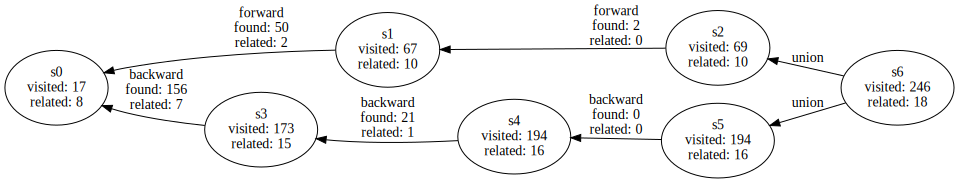

In [61]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [62]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E5
0.07317073170731707
Recall E5
0.35294117647058826
F-measure E5
0.1212121212121212


In [63]:
state.find("s0").related 

{An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [64]:
state.find("s1").related 

{An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A Low-overhead method for software process appraisal,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [65]:
state.find("s3").related 

{QFD Application in Software Process Management and Improvement Based on CMM,
 ProPAM: SPI based on Process and Project Alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 GQM+Strategies - Aligning business strategies with software measurement,
 A Low-overhead method for software process appraisal,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment,
 Linking software development and business strategy through measurement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Entropy based software processes improvement,
 Aligning software-related strategies in multi- organizational settings,
 Interfacing three complementary technol

In [66]:
sx, sy = state.previous[0]

sx.related & sy.related


{ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software process improvement: Supporting the linking of the software and the business strategies,
 A Low-overhead method for software process appraisal,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [67]:
sx.name

's2'

In [68]:
sy.name

's5'

In [69]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['liu2005a - QFD Application in Software Process Management and Improvement Based on CMM',
  'martins2007b - ProPAM: SPI based on Process and Project Alignment',
  'basili2007b - GQM+Strategies - Aligning business strategies with software measurement',
  'basili2007a - Bridging the gap between business strategy and software development',
  'basili2010a - Linking software development and business strategy through measurement',
  'trienekens2009a - Entropy based software processes improvement',
  'kowalczyk2010a - Aligning software-related strategies in multi- organizational settings',
  'mccoy1998a - Interfacing three complementary technologies: Strategic planning, process modeling, and system dynamics'],
 ['stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach',
  'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']]

In [70]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

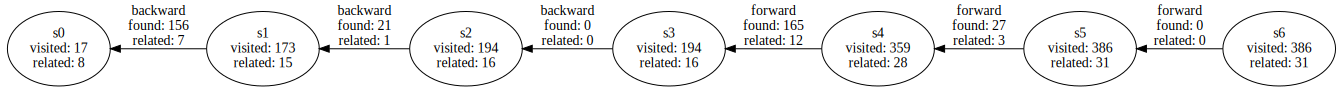

In [71]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [72]:
strategy._repeat??

In [73]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E6
0.08031088082901554
Recall E6
0.6078431372549019
F-measure E6
0.14187643020594964


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

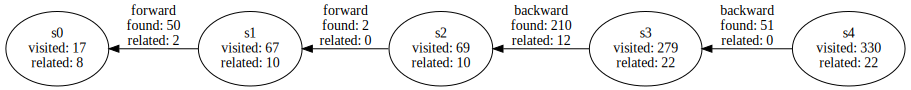

In [74]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [75]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

Precision E7
0.06666666666666667
Recall E7
0.43137254901960786
F-measure E7
0.11548556430446195


# Análise das Estratégias

In [76]:
%matplotlib notebook
import pandas as pd

In [77]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall','F-Measure'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall,F-Measure
Estratégia,,,,
E1,E1,0.470588,0.156863,0.235294
E2,E2,0.033217,0.745098,0.063598
E3,E3,0.052065,0.568627,0.095395
E4,E4,0.056338,0.705882,0.104348
E5,E5,0.073171,0.352941,0.121212
E6,E6,0.080311,0.607843,0.141876
E7,E7,0.066667,0.431373,0.115486


<IPython.core.display.Javascript object>


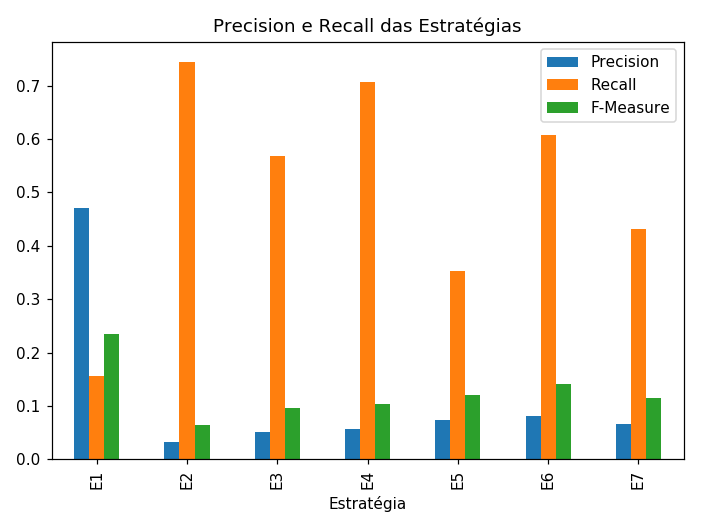

In [78]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [79]:
df

,Estratégia,Precision,Recall,F-Measure
Estratégia,,,,
E1,E1,0.470588,0.156863,0.235294
E2,E2,0.033217,0.745098,0.063598
E3,E3,0.052065,0.568627,0.095395
E4,E4,0.056338,0.705882,0.104348
E5,E5,0.073171,0.352941,0.121212
E6,E6,0.080311,0.607843,0.141876
E7,E7,0.066667,0.431373,0.115486


In [80]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

# Individual

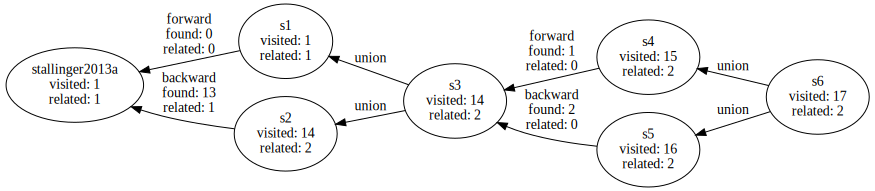

In [85]:
reload()
#NAME = "guzmán2010a"
NAME = "sun2010a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

In [82]:
state.find("s1").delta_visited

set()

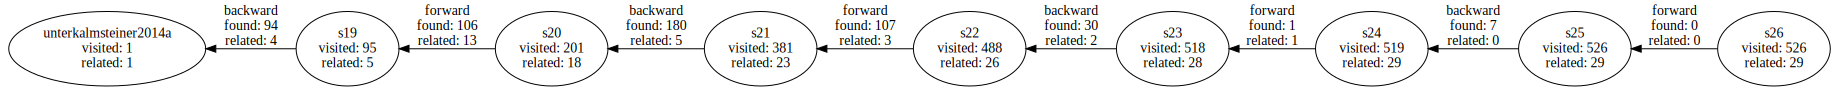

In [83]:
strategy.bfbf()